In [1]:
import torch
import torchvision
import random
import matplotlib.pyplot as plt
import os
import copy
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from PIL import Image

#run command in folder with corrupted images to get rid of them
#find . -name "*.jpg" -size -16k -delete

In [2]:
train = 0.8
#run this cell to create a training and testing split
'''
for c in os.listdir('data/train'):
    train_dir = os.path.join('data/train',c)
    valid_dir = os.path.join('data/valid',c)
    os.mkdir(valid_dir)
    total_samples=len(os.listdir(train_dir))
    datalist=os.listdir(train_dir)
    
    random_idx = random.sample(range(total_samples), total_samples)
    train_idx = random_idx[0:int(total_samples*train)]
    valid_idx = random_idx[int(total_samples*train)+1:total_samples]
    for idx in valid_idx:
        os.rename(os.path.join(train_dir,datalist[idx]),os.path.join(valid_dir,datalist[idx]))

'''

'\nprint("here 1")\nfor c in os.listdir(\'data/train\'):\n    train_dir = os.path.join(\'data/train\',c)\n    valid_dir = os.path.join(\'data/valid\',c)\n    os.mkdir(valid_dir)\n    total_samples=len(os.listdir(train_dir))\n    datalist=os.listdir(train_dir)\n    \n    random_idx = random.sample(range(total_samples), total_samples)\n    train_idx = random_idx[0:int(total_samples*train)]\n    valid_idx = random_idx[int(total_samples*train)+1:total_samples]\n    for idx in valid_idx:\n        os.rename(os.path.join(train_dir,datalist[idx]),os.path.join(valid_dir,datalist[idx]))\n\n'

In [3]:
data_dir = "data"
train_data = datasets.ImageFolder('data/train')
num_classes = len(train_data.classes)
model_name = "densenet"  # resnet, vgg or densenet
input_size = 224  # DenseNet Characteristic
batch_size = 16
feature_extract = False

In [5]:
data_dir = "data"
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation([0, 90]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

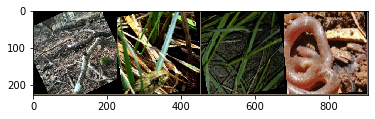

In [6]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

# Get a mini-batch of training data
mini_batch = 4
dataloaders_dict_visualize = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=mini_batch, shuffle=True, num_workers=4) for x in ['train']}
inputs, classes = next(iter(dataloaders_dict_visualize['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)


In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_fscore = 0.0
    
    loss_train_evo=[]
    acc_train_evo=[]
    fs_train_evo=[]
    
    loss_val_evo=[]
    acc_val_evo=[]
    fs_val_evo=[]
    
    total_train=round(47626/batch_size)

    for epoch in range(num_epochs):
        i = 0
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            fscore = []
            cscore = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    #"""
                    if i==round(0.25*total_train):
                        print('Forward Passed 25%')
                    if i==round(0.5*total_train):
                        print('Forward Passed 50%')
                    if i==round(0.75*total_train):
                        print('Forward Passed 75%')
                    i = i + 1
                    #"""
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                Fscore = f1_score(labels_cpu, predictions_cpu, average='macro')
                fscore.append(Fscore)
                Cscore = cohen_kappa_score(labels_cpu, predictions_cpu)
                cscore.append(Cscore)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_fscore = np.average(np.array(fscore))
            epoch_cscore = np.average(np.array(cscore))
            print('{} Loss: {:.4f} Acc: {:.4f} F-score: {:.3f} Cohen-score: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_fscore,epoch_cscore))
            
            if phase == 'train':
                loss_train_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_train_evo.append(epoch_acc)
                fs_train_evo.append(epoch_fscore)                
            else:
                loss_val_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_val_evo.append(epoch_acc)
                fs_val_evo.append(epoch_fscore) 
                
            # deep copy the model
            if phase == 'valid' and epoch_fscore > best_fscore:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train_evo, acc_train_evo, fs_train_evo, loss_val_evo, acc_val_evo, fs_val_evo

# sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":  # ResNet-50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":  # VGG-11
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "densenet":  # DenseNet-121
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        # DROPOUT
        model_ft.features.denseblock4.denselayer8.relu2 = nn.Sequential(
            nn.Dropout2d(0.15),
            nn.ReLU(inplace=True)
        )
        model_ft.features.denseblock4.denselayer16.relu2 = nn.Sequential(
            nn.Dropout2d(0.15),
            nn.ReLU(inplace=True)
        )
        model_ft.classifier = nn.Sequential(
            nn.Dropout2d(0.5),
            nn.Linear(num_ftrs,num_classes)
        )
        input_size = 224

    elif model_name == "inception":  # inception
        model_ft =  models.inception_v3(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    return model_ft, input_size


In [9]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            a=1 # print("\t",name)
            
# Optimizer
optimizer_ft = optim.Adam(params_to_update, lr=3e-4, weight_decay=0.001)

# Loss Funciton
weights=[]
for c in os.listdir('data/train'):
    train_dir=os.path.join('data/train',c)
    weights.append(len(os.listdir(train_dir)))
weights = [sum(weights) / x for x in weights]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [10]:
num_epochs = 12
model_ft, loss_train, acc_train, fs_train, loss_val, acc_val, fs_val = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
# Save model
torch.save(model_ft.state_dict(),'data/model_baseline_inception.pth')

Epoch 1/12


/home/vmuser/anaconda3/envs/snake/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vmuser/anaconda3/envs/snake/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Forward Passed 25%
Forward Passed 50%
train Loss: 2.5480 Acc: 0.2800 F-score: 0.174 Cohen-score: 0.235
Forward Passed 75%
valid Loss: 2.0898 Acc: 0.3667 F-score: 0.240 Cohen-score: 0.318
Epoch 2/12
Forward Passed 25%
Forward Passed 50%
train Loss: 2.1833 Acc: 0.3574 F-score: 0.233 Cohen-score: 0.316
Forward Passed 75%
valid Loss: 1.8624 Acc: 0.4112 F-score: 0.280 Cohen-score: 0.370
Epoch 3/12
Forward Passed 25%
Forward Passed 50%
train Loss: 2.0643 Acc: 0.3834 F-score: 0.256 Cohen-score: 0.342
Forward Passed 75%
valid Loss: 1.7713 Acc: 0.4392 F-score: 0.297 Cohen-score: 0.396
Epoch 4/12
Forward Passed 25%
Forward Passed 50%
train Loss: 1.9920 Acc: 0.4017 F-score: 0.270 Cohen-score: 0.361
Forward Passed 75%
valid Loss: 1.8019 Acc: 0.4368 F-score: 0.298 Cohen-score: 0.395
Epoch 5/12
Forward Passed 25%
Forward Passed 50%
train Loss: 1.9419 Acc: 0.4147 F-score: 0.281 Cohen-score: 0.374
Forward Passed 75%
valid Loss: 1.8089 Acc: 0.4403 F-score: 0.304 Cohen-score: 0.396
Epoch 6/12
Forward Pa

In [13]:
# Load the pretrained model
model_weights_path = 'data/model_baseline_inception.pth'
model_weights = torch.load(model_weights_path)
model_ft.load_state_dict(model_weights)
print('Model Loaded')

Model Loaded


Actual name of snake /home/vmuser/CV_proj/data/train/class-460/3e5927e18ff39955009778085accb4ec.jpg
Predicted class:  Crotalus Ruber


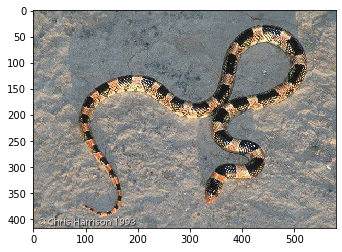

In [22]:
def get_item():
    test_files = os.listdir('data/test')
    idx = random.randint(0,len(test_files))
    #ima_dir = os.path.join('data/test',test_files[idx])
    ima_dir = "/home/vmuser/CV_proj/data/train/class-460/3e5927e18ff39955009778085accb4ec.jpg"
    print("Actual name of snake", ima_dir)
    scaler = transforms.Resize((224, 224))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    to_tensor = transforms.ToTensor()
    ima = Image.open(ima_dir)
    plt.imshow(ima)
    item = (normalize(to_tensor(scaler(ima))).unsqueeze(0)).to(device)
    return item

class_name = ['Thamnophis Proximus', 'Nerodia Sipedon', 'Opheodrys Vernalis', 'Crotalus Horridus', 'Crotalus Pyrrhus', 'Nerodia Rhombifer', 'Thamnophis Sirtalis', 'Natrix Natrix', 'Crotalus Adamanteus', 'Charina Bottae', 'Pituophis Catenifer', 'Lampropeltis Triangulum', 'Nerodia Erythrogaster', 'Thamnophis Marcianus', 'Lampropeltis Californiae', 'Crotalus Ruber', 'Rhinocheilus Lecontei', 'Opheodrys Aestivus', 'Thamnophis Ordinoides', 'Thamnophis Radix', 'Masticophis Flagellum', 'Pantherophis Vulpinus', 'Hierophis Viridiflavus', 'Feterodon Platirhinos', 'Pantherophis Emoryi', 'Regina Septemvittata', 'Haldea Striatula', 'Diadophis Punctatus', 'Nerodia Fasciata', 'Storeria Occipitomaculata', 'Crotalus Scutulatus', 'Storeria Dekayi', 'Crotalus Viridis', 'Boa Imperator', 'Pantherophis Obsoletus', 'Lichanura Trivirgata', 'Agkistrodon Contortrix', 'Thamnophis Elegans', 'Agkistrodon Piscivorus', 'Pantherophis Guttatus', 'Crotalus Atrox', 'Carphophism Amoenus', 'Coluber Constrictor', 'Pantherophis Spiloides', 'Pantherophis Alleghaniensis']
item = get_item()
model_ft.eval()
output = model_ft(item)
_, preds = torch.max(output, 1)
class_id = preds.item()
print("Predicted class: ", class_name[class_id])
